In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import model.cnn as cnn
import model.explainn as explainn
import feature.simulated_dataset as simulated_dataset
import train.train_model as train_model
import train.performance as performance
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
datasets = [
    "SPI1", "TAL/GATA", "E2F6", "JUND/TEAD", "REST", "SPI1/CTCF"
]

In [6]:
mechint_model_paths = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/mechint_net/2/last_ckpt.pth"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/mechint_net/2/last_ckpt.pth"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/mechint_net/2/last_ckpt.pth"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/mechint_net/2/last_ckpt.pth"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/mechint_net/2/last_ckpt.pth"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/mechint_net/3/last_ckpt.pth")
}
cnn_model_paths = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/standard_cnn/1/last_ckpt.pth"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/standard_cnn/3/last_ckpt.pth"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/standard_cnn/1/last_ckpt.pth"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/standard_cnn/2/last_ckpt.pth"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/standard_cnn/1/last_ckpt.pth"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/standard_cnn/1/last_ckpt.pth")
}
explainn_model_paths = {
    "SPI1": os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/explainn/1/last_ckpt.pth"),
    "TAL/GATA": os.path.join(base_path, "models/trained_models/simulated/tal_gata_exp_mix/explainn/1/last_ckpt.pth"),
    "E2F6": os.path.join(base_path, "models/trained_models/simulated/e2f6_max_exp_coop/explainn/2/last_ckpt.pth"),
    "JUND/TEAD": os.path.join(base_path, "models/trained_models/simulated/jund_tead_exp_hard_spacing/explainn/3/last_ckpt.pth"),
    "REST": os.path.join(base_path, "models/trained_models/simulated/rest_exp_both/explainn/2/last_ckpt.pth"),
    "SPI1/CTCF": os.path.join(base_path, "models/trained_models/simulated/spi1_ctcf_exp_repress/explainn/1/last_ckpt.pth")
}

In [7]:
motif_config_paths = {
    "SPI1": [os.path.join(base_path, "data/simulations/configs/spi1_exp_single_config.json")],
    "TAL/GATA": [os.path.join(base_path, "data/simulations/configs/tal_gata_exp_mix_config.json")],
    "E2F6": [os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_config.json"), os.path.join(base_path, "data/simulations/configs/e2f6_max_exp_coop_neg_config.json")],
    "JUND/TEAD": [os.path.join(base_path, "data/simulations/configs/jund_tead_exp_hard_spacing_config.json")],
    "REST": [os.path.join(base_path, "data/simulations/configs/rest_exp_both_config.json"), os.path.join(base_path, "data/simulations/configs/rest_exp_both_neg_config.json")],
    "SPI1/CTCF": [os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_config.json"), os.path.join(base_path, "data/simulations/configs/spi1_ctcf_exp_repress_neg_config.json")],
}

In [11]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/gc_robustness"
os.makedirs(figures_out_path, exist_ok=True)

### Test performance over backgrounds of varying GC content

In [9]:
gc_percs_to_try = np.arange(0.05, 1.0, 0.05)
mechint_metrics, cnn_metrics, explainn_metrics = {}, {}, {}
for dataset_key in datasets:
    print(dataset_key)
    
    # Import models
    mechint_model = model_util.load_model(
        mechint_net.MechIntRegNet, mechint_model_paths[dataset_key]
    ).to(DEVICE)
    cnn_model = model_util.load_model(
        cnn.ConvNet, cnn_model_paths[dataset_key]
    ).to(DEVICE)
    explainn_model = model_util.load_model(
        explainn.ExplaiNN, explainn_model_paths[dataset_key]
    ).to(DEVICE)

    # Create several backgrounds based on GC content
    mechint_metrics[dataset_key] = []
    cnn_metrics[dataset_key] = []
    explainn_metrics[dataset_key] = []
    
    for gc_perc in gc_percs_to_try:
        gc_perc_half = gc_perc / 2
        
        # Create alternative data loader with different background
        alt_data_loader = simulated_dataset.dataset_ex.run(
            "create_data_loader", config_updates={
                "motif_config_path": motif_config_paths[dataset_key][0],
                "input_length": 500,
                "motif_center_dist_bound": 50,
                "batch_size": 128,
                "num_batches": 1,
                "background_match_reject_prob": 1,
                "neg_motif_config_path": motif_config_paths[dataset_key][1] if len(motif_config_paths[dataset_key]) > 1 else None,
                "bg_seq_freqs": np.array([0.5 - gc_perc_half, gc_perc_half, gc_perc_half, 0.5 - gc_perc_half])
            }
        ).result
    
        # Run batch
        mechint_losses_batched, _, mechint_model_outputs, _, _, mechint_input_data = \
            train_model.run_epoch(alt_data_loader, "eval", mechint_model, epoch_num=0, return_extras=True)
        cnn_losses_batched, _, cnn_model_outputs, _, _, cnn_input_data = \
            train_model.run_epoch(alt_data_loader, "eval", cnn_model, epoch_num=0, return_extras=True)
        explainn_losses_batched, _, explainn_model_outputs, _, _, explainn_input_data = \
            train_model.run_epoch(alt_data_loader, "eval", explainn_model, epoch_num=0, return_extras=True)
    
        # Compute performance
        mechint_metrics[dataset_key].append(performance.compute_performance_metrics(
            np.squeeze(mechint_input_data[1], axis=1), np.squeeze(mechint_model_outputs, axis=1)
        ))
        cnn_metrics[dataset_key].append(performance.compute_performance_metrics(
            np.squeeze(cnn_input_data[1], axis=1), np.squeeze(cnn_model_outputs, axis=1)
        ))
        explainn_metrics[dataset_key].append(performance.compute_performance_metrics(
            np.squeeze(explainn_input_data[1], axis=1), np.squeeze(explainn_model_outputs, axis=1)
        ))

SPI1


WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14738d213200>
INFO - sim_dataset - Completed after 0:00:00
	Loss: 0.3438: 100%|███████████████████████████████████████████████████████████

TAL/GATA


	Loss: 0.3668: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14738d0574d0>
INFO -

E2F6


	Loss: 0.2339: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14738d1184a0>
INFO -

JUND/TEAD


	Loss: 0.0702: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14733c052b40>
INFO -

REST


	Loss: 0.3114: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14738d119130>
INFO -

SPI1/CTCF


	Loss: 0.3273: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]
WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x14738d055580>
INFO -

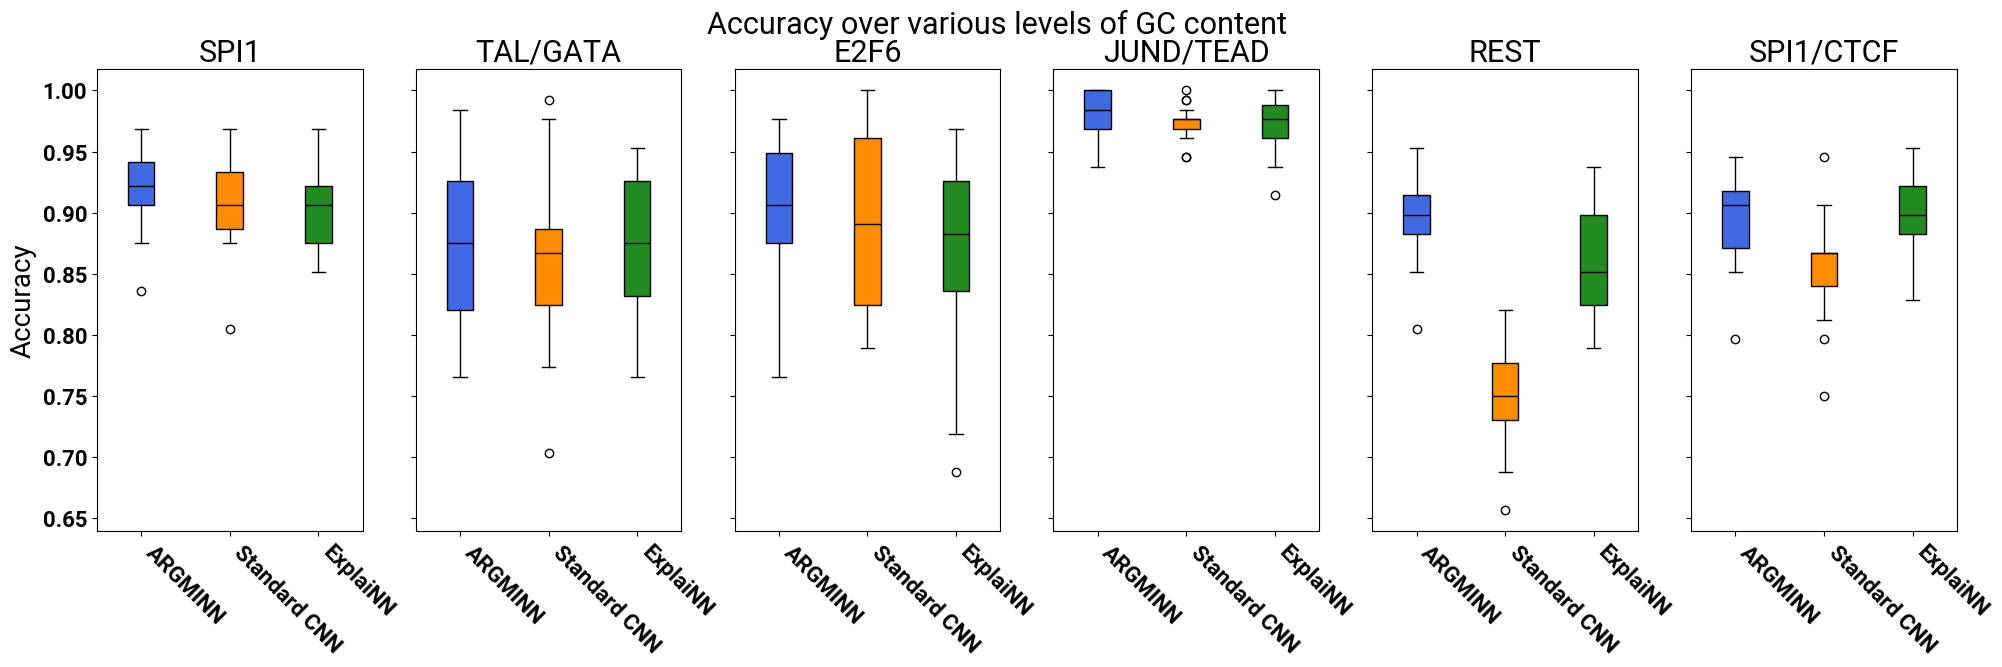

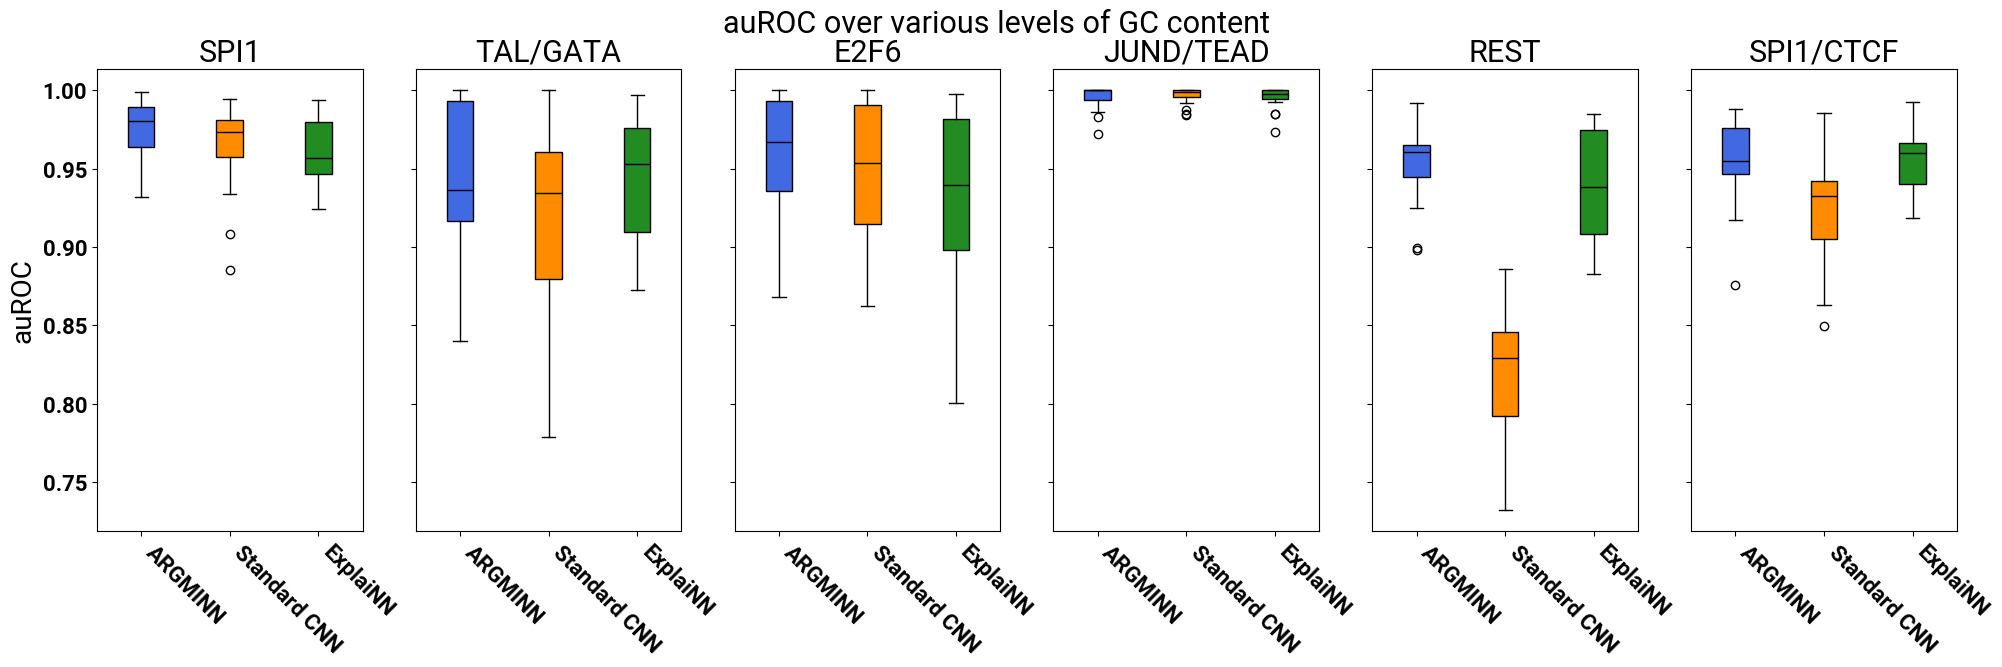

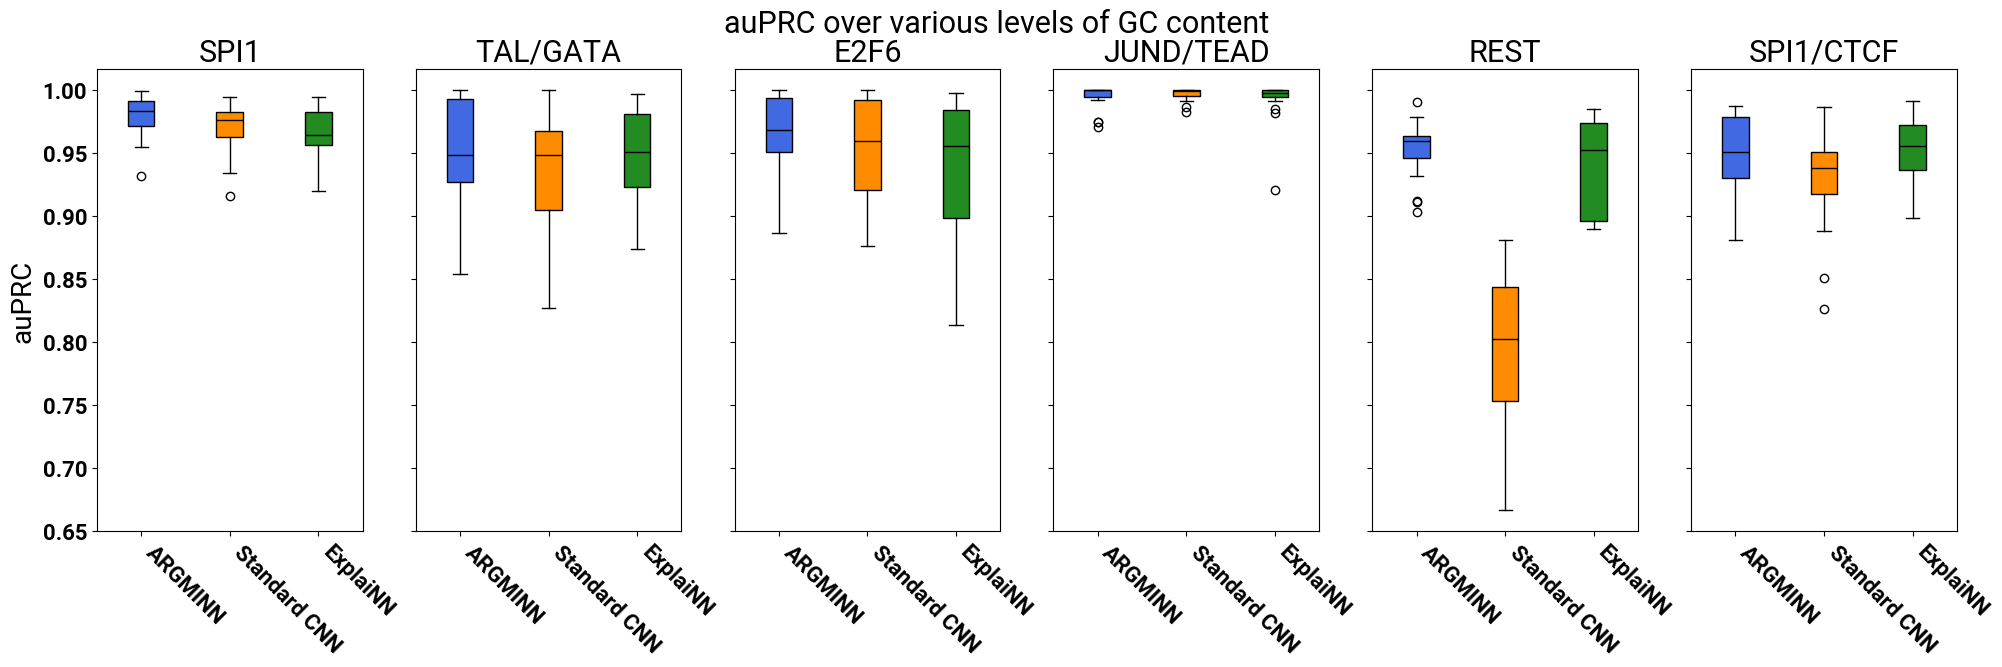

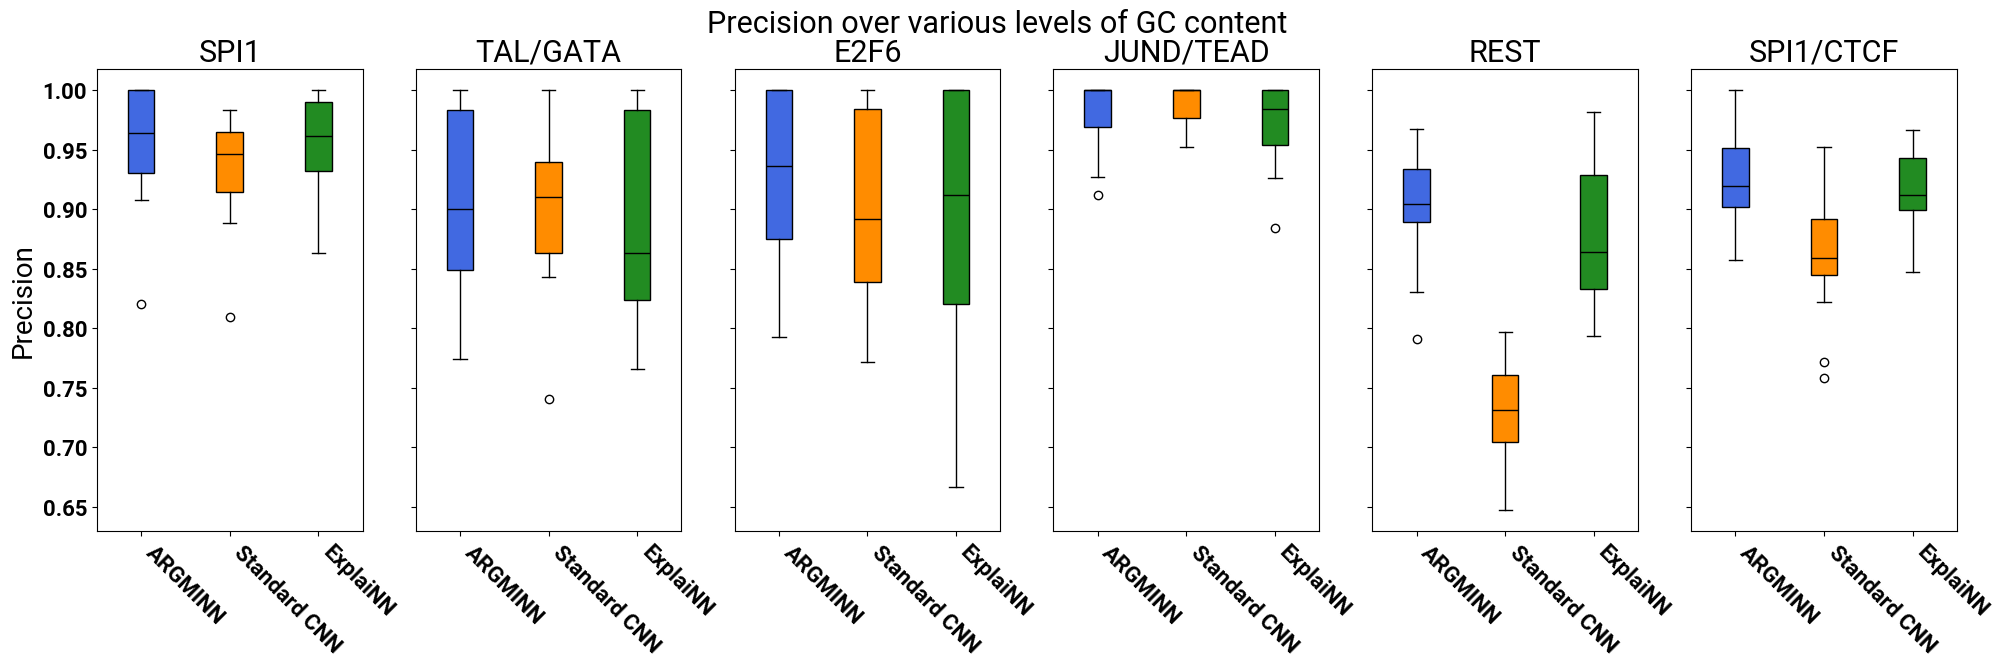

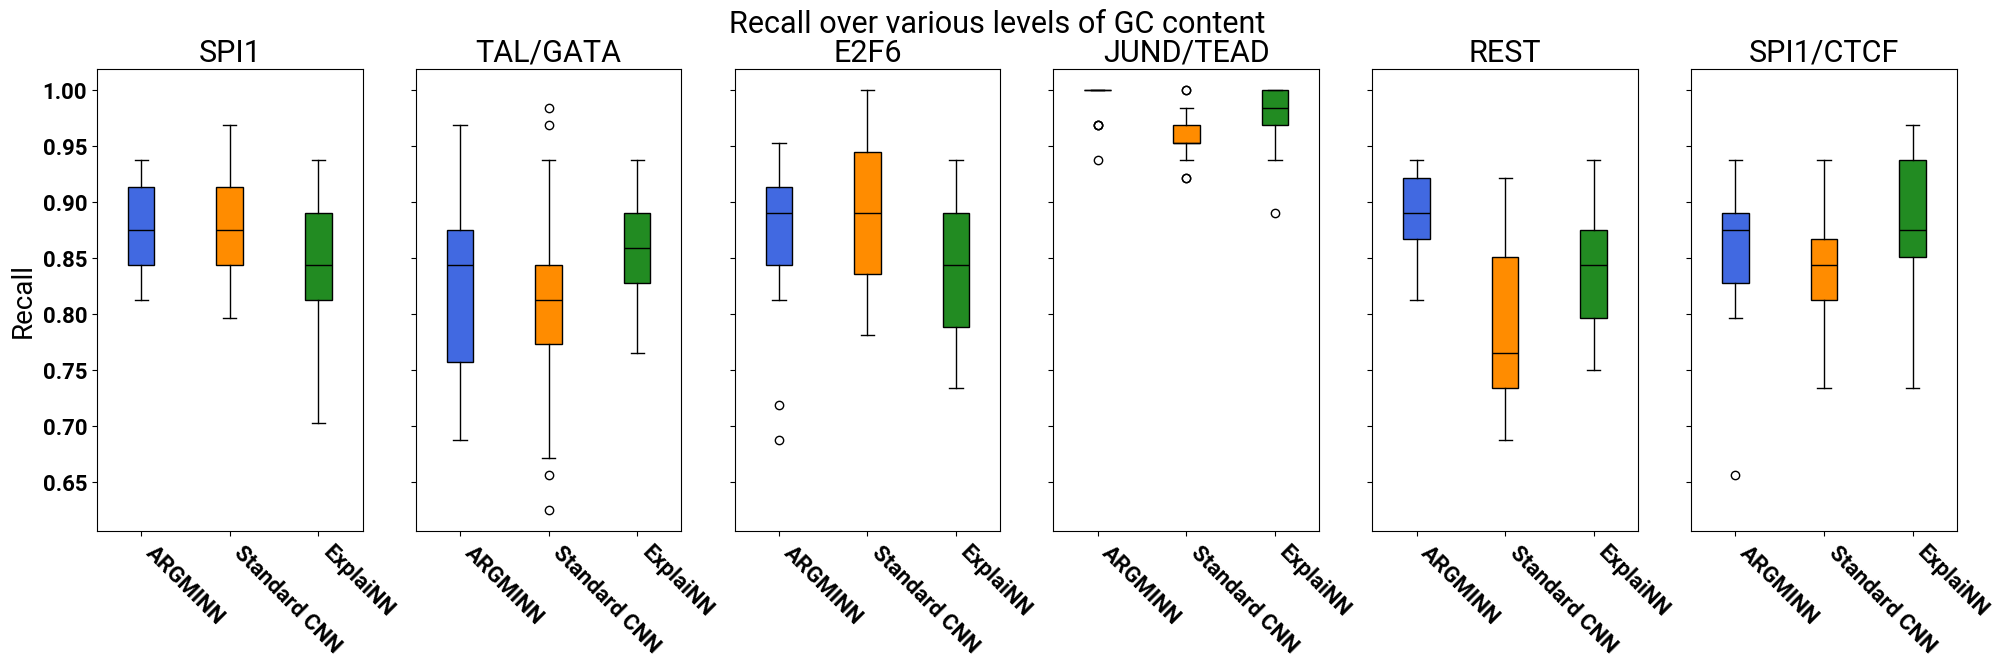

In [12]:
# Plot distribution of metrics
metric_keys = ("acc", "auroc", "auprc", "precis", "recall")
metric_names = ("Accuracy", "auROC", "auPRC", "Precision", "Recall")

for metric_key, metric_name in zip(metric_keys, metric_names):
    fig, ax = plt.subplots(ncols=len(datasets), sharey=True, figsize=(4 * len(datasets), 6))
    for i, dataset_key in enumerate(datasets):
        boxes = ax[i].boxplot(
            [
                [metrics[metric_key] for metrics in mechint_metrics[dataset_key]],
                [metrics[metric_key] for metrics in cnn_metrics[dataset_key]],
                [metrics[metric_key] for metrics in explainn_metrics[dataset_key]]
            ],
            vert=True, patch_artist=True
        )
        boxes["boxes"][0].set_facecolor("royalblue")
        boxes["boxes"][1].set_facecolor("darkorange")
        boxes["boxes"][2].set_facecolor("forestgreen")
        for line in boxes["medians"]:
            line.set_color("black")
        ax[i].set_title(dataset_key)
        ax[i].set_xticklabels(["ARGMINN", "Standard CNN", "ExplaiNN"], rotation=-45, ha="left")
    ax[0].set_ylabel(metric_name)
    fig.suptitle("%s over various levels of GC content" % metric_name)
    fig.savefig(os.path.join(figures_out_path, "%s_gcrobust_box.svg" % metric_key), format="svg")
    plt.show()